In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from kerastuner import RandomSearch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
num_classes = 2

# Image Data Generators for augmenting and rescaling images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
# Load training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # VGG16 expects 224x224 images
    batch_size=32,
    class_mode='categorical'  # Categorical for multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 194 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [5]:
number_of_class = 2

In [6]:
def build_model(hp):
    # Load the base VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    # Add custom layers on top
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Use Global Average Pooling to reduce dimensionality before the dense layers
    x = GlobalAveragePooling2D()(x)

    # Add fully connected layers with Dropout for regularization
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(number_of_class, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with tunable optimizer and learning rate
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
# Initialize Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train with each combination
    directory='tuner_results',
    project_name='vgg16_tuning'
)

In [8]:
number_of_epochs = 30

In [9]:
# Run the hyperparameter search
tuner.search(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Trial 2 Complete [00h 04m 02s]
val_accuracy: 0.6785714328289032

Best val_accuracy So Far: 0.6785714328289032
Total elapsed time: 00h 08m 08s


In [10]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# Optional: Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_generator)
print(f"Best model validation loss: {loss}")
print(f"Best model validation accuracy: {accuracy}")

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
{'optimizer': 'adam'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6429 - loss: 0.6201
Best model validation loss: 0.6201176047325134
Best model validation accuracy: 0.6428571343421936


In [11]:
# Save the model, optional
best_model.save(f'Pth_Files/VGG16_{number_of_epochs}.keras')

In [18]:
predictions = best_model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  # Get class labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [21]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')  # 'weighted' to handle class imbalance
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Create a DataFrame to display statistics
stats_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1]
})

# Display the DataFrame
print(stats_df)

      Metric     Value
0   Accuracy  0.428571
1  Precision  0.428571
2     Recall  0.428571
3   F1-Score  0.428571


In [30]:


# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Calculate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      edible       0.40      0.33      0.36        12
   poisonous       0.56      0.62      0.59        16

    accuracy                           0.50        28
   macro avg       0.48      0.48      0.48        28
weighted avg       0.49      0.50      0.49        28



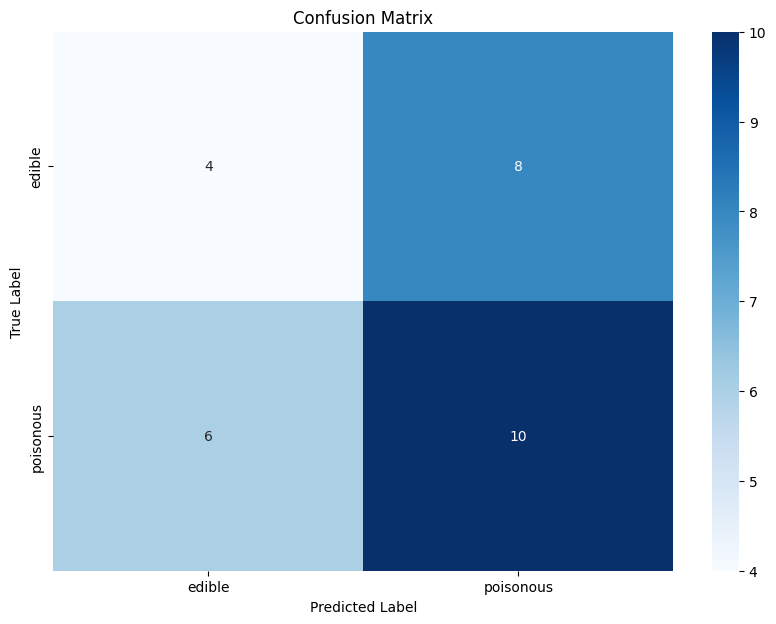

In [31]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()